### 1. Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
import hdbscan
import geopandas as gpd
import contextily as ctx
from geopy.geocoders import Nominatim
from tqdm.notebook import tqdm
from geopy.extra.rate_limiter import RateLimiter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn import tree

import sys
import os
sys.path.append(os.path.abspath('..'))
from datetime import datetime
from functions.shap_forceplots import clust_shap_force

### 2. Import schoolgaanden

In [2]:
# Choose embedded space to work with
embedded_space = 'intersection'

# Load datasets
if embedded_space == 'intersection':
    X_schoolgaanden_UMAP15 = np.load('../4_Data\Arrays\X_schoolgaanden_notvaccinated_UMAP15_intersection1.npy')
elif embedded_space == 'union':
    X_schoolgaanden_UMAP15 = np.load('../4_Data\Arrays\X_schoolgaanden_notvaccinated_UMAP15_union1.npy')

y_schoolgaanden = np.load('../4_Data/Arrays/y_schoolgaanden.npy')

# Original variables
schoolgaanden = pd.read_pickle('../4_Data/Pickles/schoolgaanden.pkl')
X_schoolgaanden_notvaccinated = pd.read_pickle('../4_Data/Pickles/X_schoolgaanden_notvaccinated.pkl')
X_schoolgaanden_vaccinated = pd.read_pickle('../4_Data/Pickles/X_schoolgaanden_vaccinated.pkl')

# Split subset of X_schoolgaanden for rows which were 'Vaccinated' in y_schoolgaanden
schoolgaanden = schoolgaanden[y_schoolgaanden == 0]

In [3]:
# Loop over every column name in a df
def column_cleaner(df):
    for column in df.columns:
        ## Remove categories
        # Get position of last capital letter by iterating backwards
        pos = 0
        for i in range(len(column)-1, 0, -1):
            if column[i].isupper() and (column[i-1].islower() or column[i-1] == '_'):
                pos = i
                break
        # If there is a capital letter
        if pos != 0 and column[-1] != '_':
            # Remove everything after the before capital letter
            df.rename(columns={column: column[pos:]}, inplace=True)
        elif pos != 0 and column[-1] == '_':
            df.rename(columns={column: column[pos:] + '%'}, inplace=True)
    return df

# Manually set some other column names
def column_editor(df):
    df.rename(columns={'Inkomen_van_huishoudens40_huishoudens_met_laagste_inkomen_%': 'Huishoudens_laagste_landelijke_40%_huishoudensinkomens_%'}, inplace=True)
    df.rename(columns={'Inkomen_van_huishoudens20_huishoudens_met_hoogste_inkomen_%': 'Huishoudens_hoogste_landelijke_20%_huishoudensinkomens_%'}, inplace=True)
    df.rename(columns={'Huishoudens_tot_110_van_sociaal_minimum_%': 'Huishoudens_tot_110%_van_sociaal_minimum_%'}, inplace=True)
    df.rename(columns={'Huishoudens_tot_120_van_sociaal_minimum_%': 'Huishoudens_tot_120%_van_sociaal_minimum_%'}, inplace=True)
    df.rename(columns={'Personenautos_per_huishouden_per_huishouden': 'Personenautos_per_huishouden'}, inplace=True)
    df.rename(columns={'stedelijkheid_1.0': 'zeer_sterk_stedelijk'}, inplace=True)
    df.rename(columns={'stedelijkheid_2.0': 'sterk_stedelijk'}, inplace=True)
    df.rename(columns={'stedelijkheid_3.0': 'matig_stedelijk'}, inplace=True)
    df.rename(columns={'stedelijkheid_4.0': 'weinig_stedelijk'}, inplace=True)
    df.rename(columns={'stedelijkheid_5.0': 'niet_stedelijk'}, inplace=True)
    return df

In [4]:
# Clean notvaccinated
column_cleaner(X_schoolgaanden_notvaccinated)
column_editor(X_schoolgaanden_notvaccinated)

# Clean vaccinated
column_cleaner(X_schoolgaanden_vaccinated)
column_editor(X_schoolgaanden_vaccinated)

,percentage_geb_nederland_herkomst_nederland,percentage_huurwoningen,gemiddelde_woz_waarde_woning,Nettoarbeidsparticipatie_%,Gemiddeld_inkomen_per_inwoner_x_1_000_euro,Huishoudens_laagste_landelijke_40%_huishoudensinkomens_%,Huishoudens_hoogste_landelijke_20%_huishoudensinkomens_%,Huishoudens_met_een_laag_inkomen_%,Huish_onder_of_rond_sociaal_minimum_%,Huishoudens_tot_110%_van_sociaal_minimum_%,...,matig_stedelijk,weinig_stedelijk,niet_stedelijk,stedelijkheid_nan,Toestemming_0.0,Toestemming_1.0,Toestemming_nan,Geslacht=mannelijk,Gevaccineerd_ouder1,Gevaccineerd_ouder2
0,80.0,40.0,277.0,66.0,34.786,20.7,27.2,1.8,2.6,4.1,...,False,False,False,False,False,True,False,True,True,True
1,90.0,20.0,335.0,72.0,33.263,17.4,34.8,1.3,1.9,2.6,...,False,False,True,False,False,False,True,True,True,True
2,90.0,40.0,285.0,60.0,26.800,40.1,15.7,4.4,5.9,9.6,...,True,False,False,False,False,True,False,False,False,False
3,80.0,40.0,626.0,65.0,41.851,35.5,33.8,2.4,3.8,5.4,...,False,False,False,False,False,True,False,False,True,True
5,90.0,30.0,364.0,69.0,34.677,29.2,25.0,2.9,3.0,5.5,...,False,False,True,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14016,90.0,30.0,320.0,66.0,31.385,38.6,20.7,4.0,5.6,9.3,...,False,True,False,False,False,False,True,False,False,False
14017,80.0,30.0,291.0,62.0,28.300,32.8,18.3,4.2,6.9,9.6,...,False,False,False,False,False,True,False,True,False,False
14018,90.0,30.0,336.0,70.0,33.500,30.5,30.1,3.5,5.0,8.4,...,False,True,False,False,False,True,False,True,False,False
14023,90.0,20.0,420.0,70.0,34.900,23.6,32.4,1.5,2.2,3.4,...,True,False,False,False,False,True,False,True,False,False


### 3. Clustering

In [5]:
# Save hyperparameters
min_cluster_size = 200
min_samples = 150

# Fit HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
hdb.fit(X_schoolgaanden_UMAP15)
print(hdb.labels_)

[ 0  4  4 ...  1 -1  2]


In [6]:
# Calculate silhouette score excluding noise cluster
if -1 in hdb.labels_:
    silhouette = silhouette_score(X_schoolgaanden_UMAP15[hdb.labels_ != -1], hdb.labels_[hdb.labels_ != -1])
else:
    silhouette = silhouette_score(X_schoolgaanden_UMAP15, hdb.labels_)

print(f'The silhouette score is: {silhouette}')

The silhouette score is: 0.6483871936798096


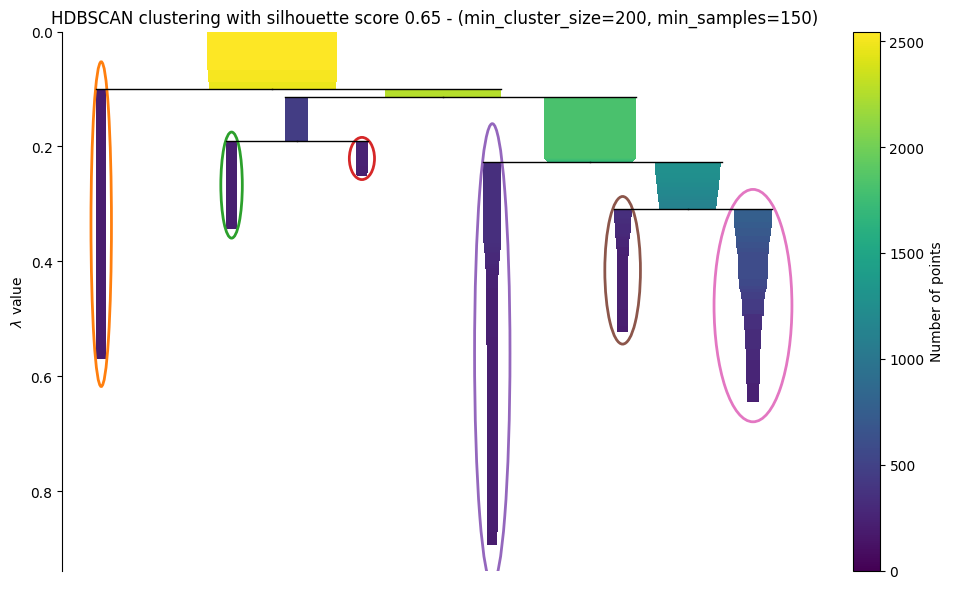

In [7]:
# If -1 is in the labels, begin with second color in palette
if -1 in hdb.labels_:
    plt.figure(figsize=(12, 7))
    plt.title(f'HDBSCAN clustering with silhouette score {silhouette:.2f} - (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette()[1:])
else:
    plt.figure(figsize=(12, 7))
    plt.title(f'HDBSCAN clustering with silhouette score {silhouette:.2f} - (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [8]:
# Plot sns.color_palette() to see the colors used in the plot
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [9]:
# Get amount of unique values in an array
unique, counts = np.unique(hdb.labels_, return_counts=True)
print(dict(zip(unique, counts)))

{-1: 436, 0: 200, 1: 210, 2: 246, 3: 346, 4: 348, 5: 761}


In [10]:
# Calculate the amount of clusters
if -1 in hdb.labels_:
    n_clusters = len(np.unique(hdb.labels_)) - 1 # Subtract 1 because of the noise cluster
else:
    n_clusters = len(np.unique(hdb.labels_))
print(f'The amount of clusters derived is: {n_clusters}')

The amount of clusters derived is: 6


### 4. Interpretation of clustering results

#### 4.1 Random Forest predictive capability

In [11]:
# Save cluster labels as y
y_clusters_schoolgaanden = hdb.labels_

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_schoolgaanden_notvaccinated, y_clusters_schoolgaanden, test_size=0.3, random_state=42)

In [ ]:
shap.initjs()

In [14]:
# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier(random_state=42)

# Train the classifier
clf_rf.fit(X_train, y_train)

# Make predictions
y_pred = clf_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.96      0.93       120
           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        69
           3       1.00      1.00      1.00       104
           4       1.00      1.00      1.00       113
           5       0.98      0.95      0.96       239

    accuracy                           0.98       765
   macro avg       0.98      0.99      0.98       765
weighted avg       0.98      0.98      0.98       765

Confusion Matrix:
[[115   0   0   0   0   0   5]
 [  0  57   0   0   0   0   0]
 [  0   0  63   0   0   0   0]
 [  0   0   0  69   0   0   0]
 [  0   0   0   0 104   0   0]
 [  0   0   0   0   0 113   0]
 [ 13   0   0   0   0   0 226]]


In [15]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(clf_rf)
shap_values = explainer.shap_values(X_train)

In [16]:
le_classes = np.unique(y_clusters_schoolgaanden)

In [ ]:
clust_shap_force(clf_rf, 21,
                 X_train, y_train,
                 explainer,
                 shap_values,
                 le_classes,
                 classes='all')

***************************************************
Ground Truth Label: 4 - 3

Model Prediction:  [4] - 3 -- Correct!
***************************************************


-1 Class (0)



0 Class (1)



1 Class (2)



2 Class (3)



3 Class (4)



4 Class (5)



5 Class (6)


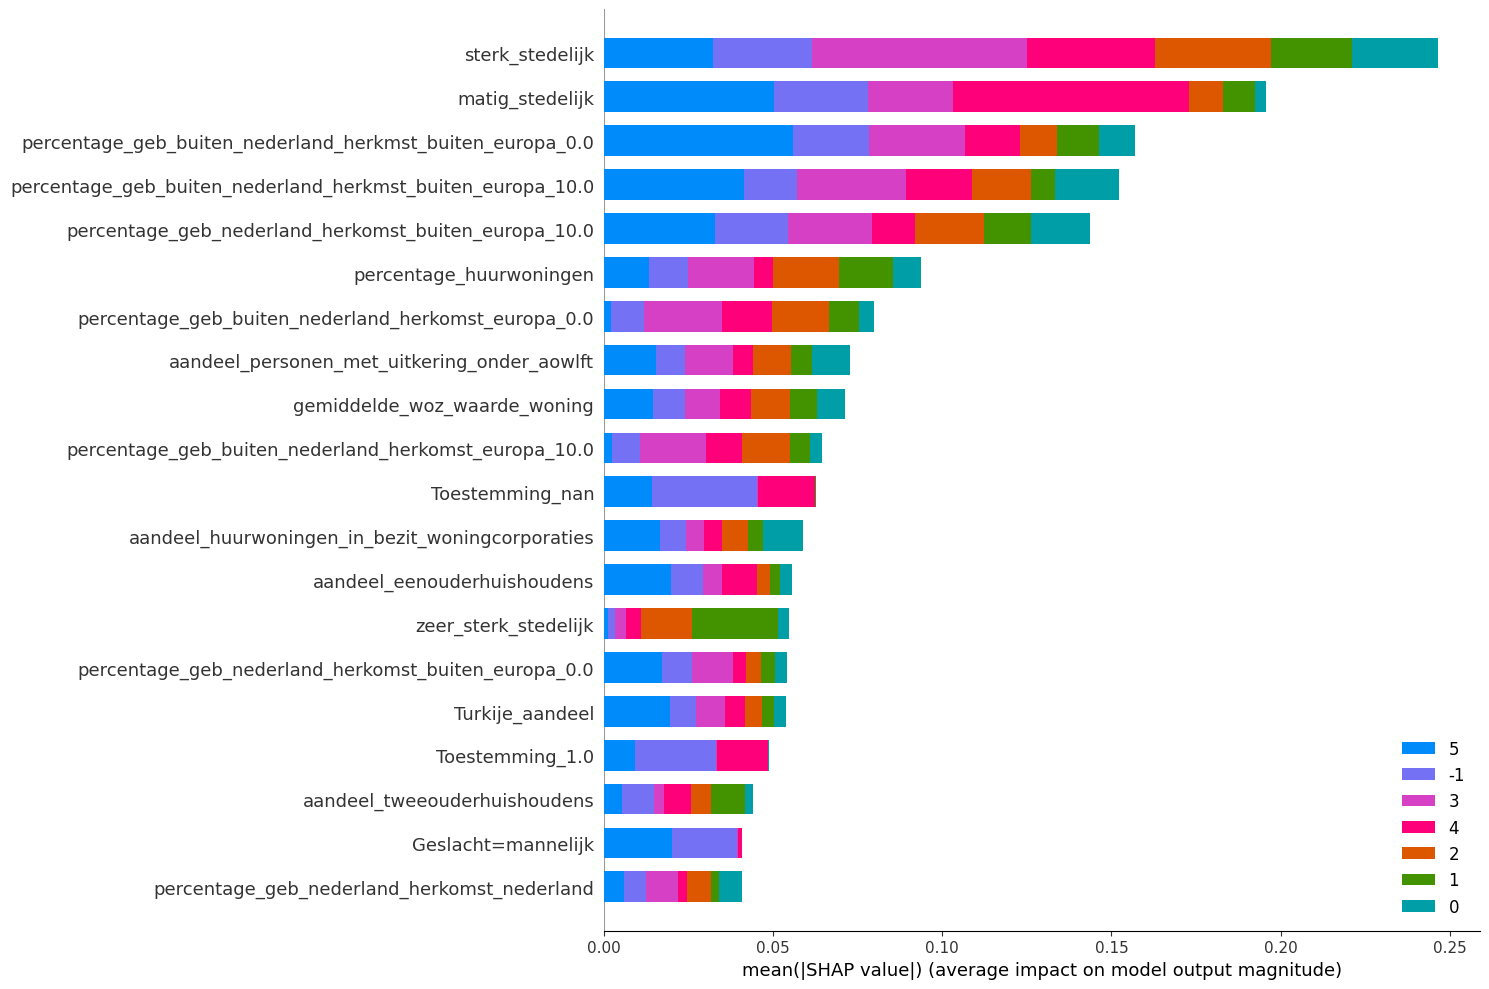

In [18]:
# Split the array into a list of arrays, one for each class
multi_shap_vals = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# Plot the SHAP values with feature names
shap.summary_plot(multi_shap_vals, X_train.values, plot_type='bar', class_names=le_classes, feature_names=X_train.columns, plot_size=(15, 10))

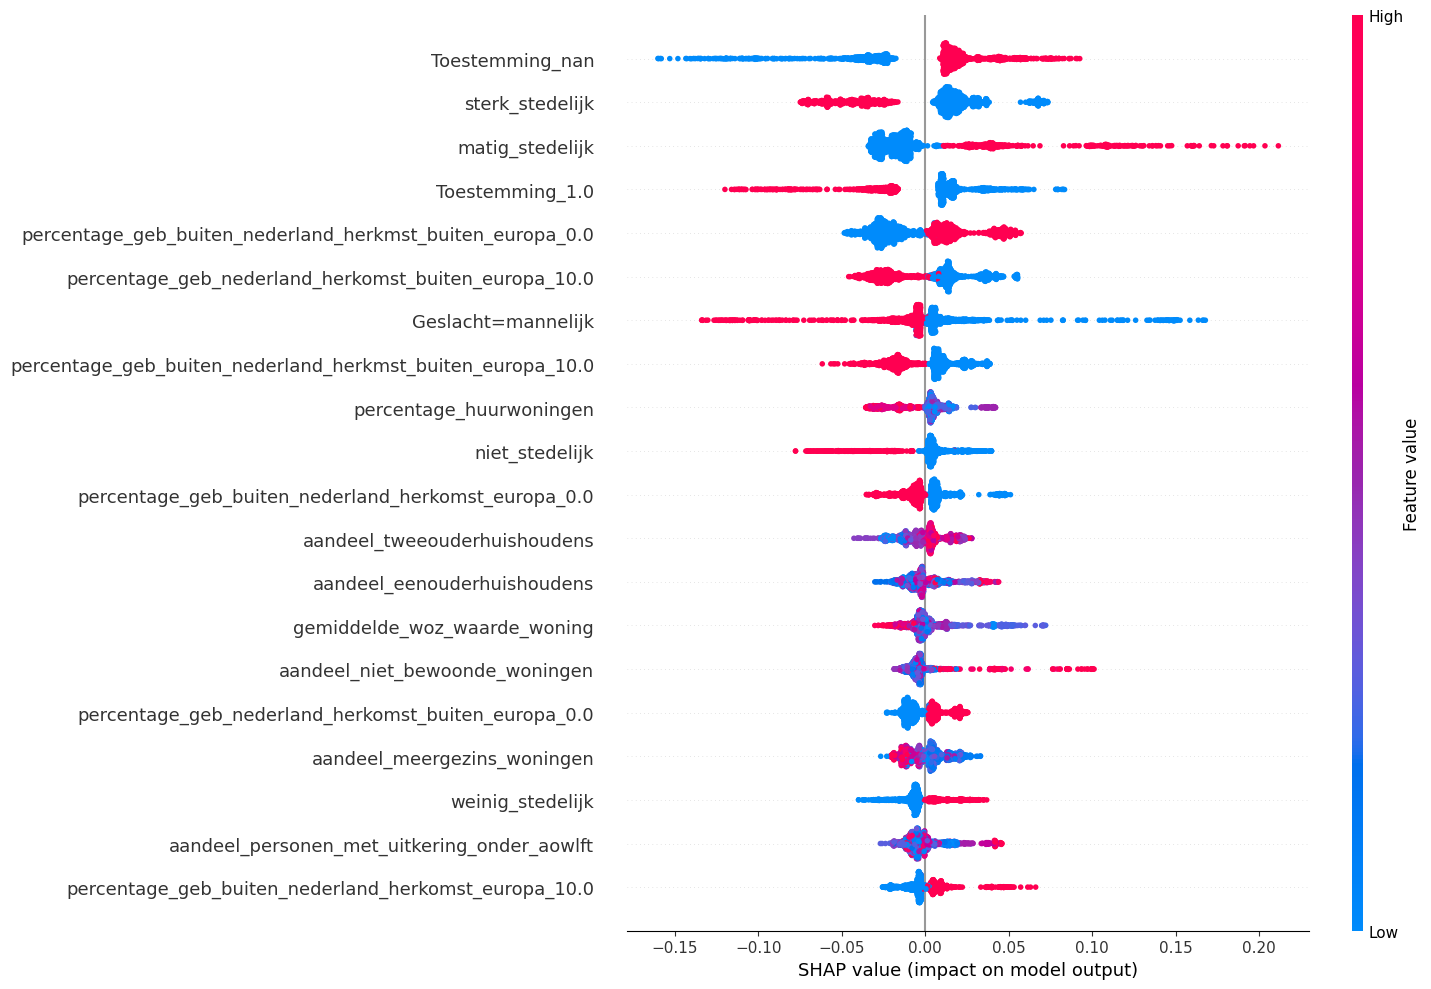

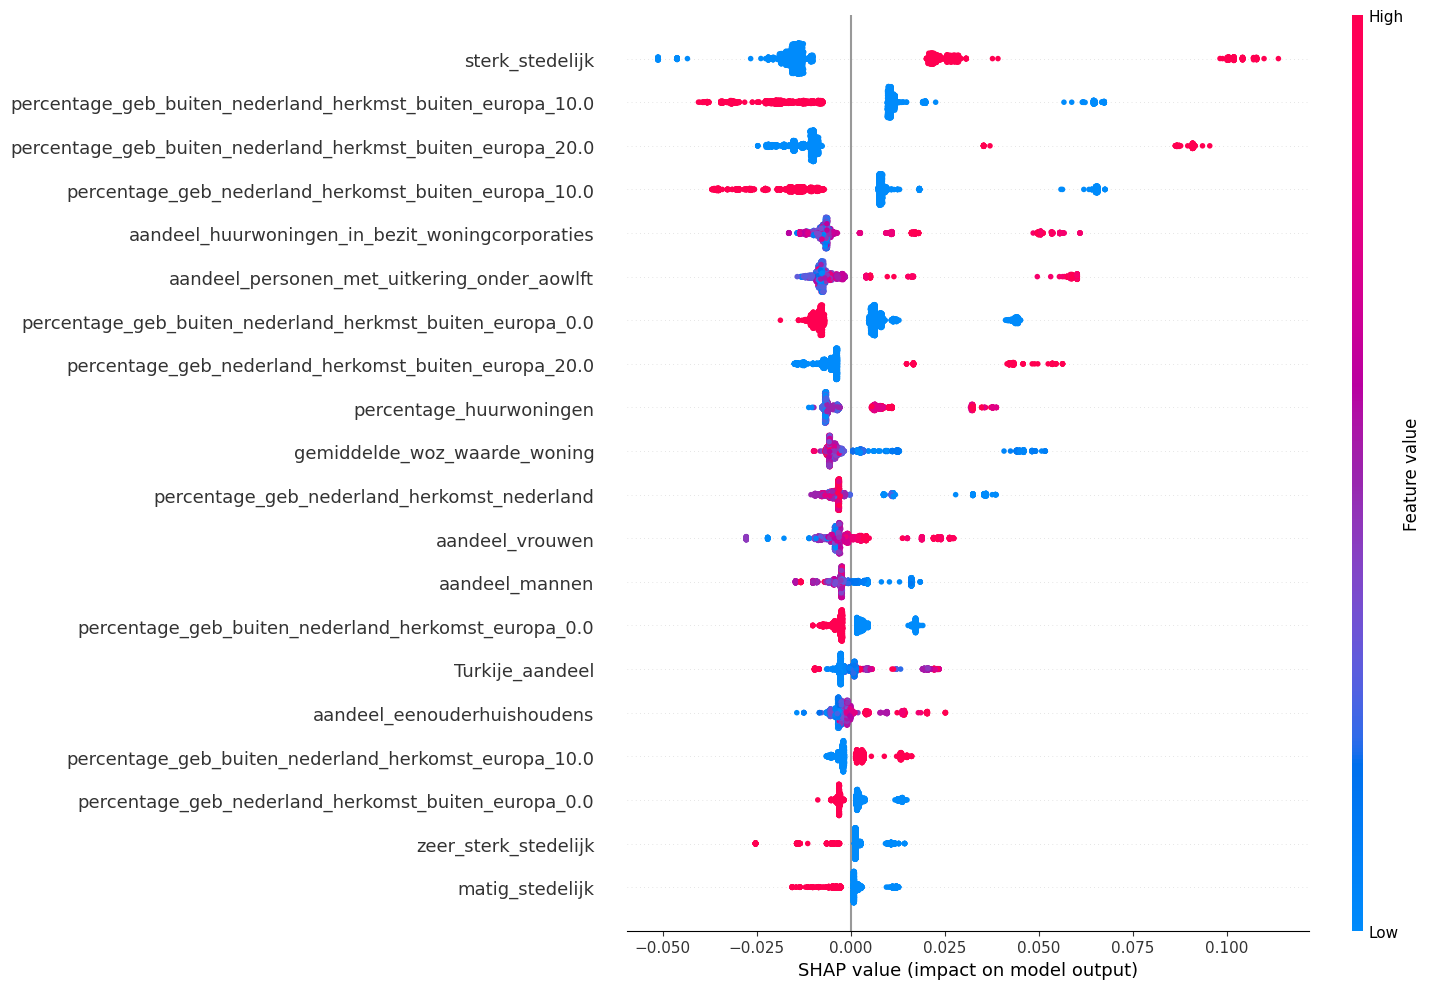

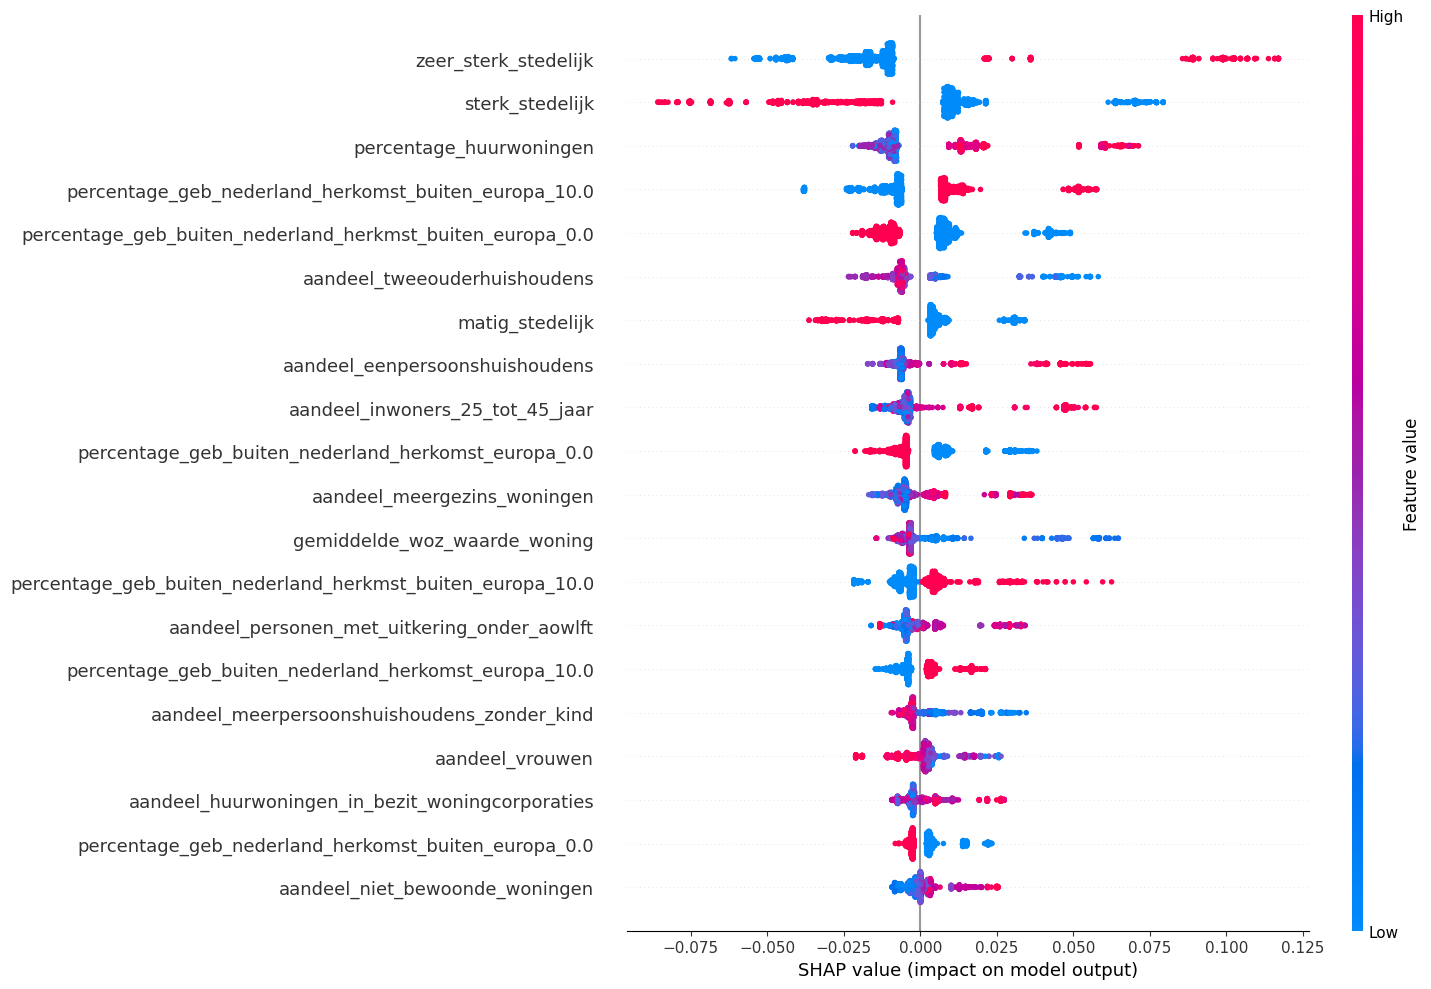

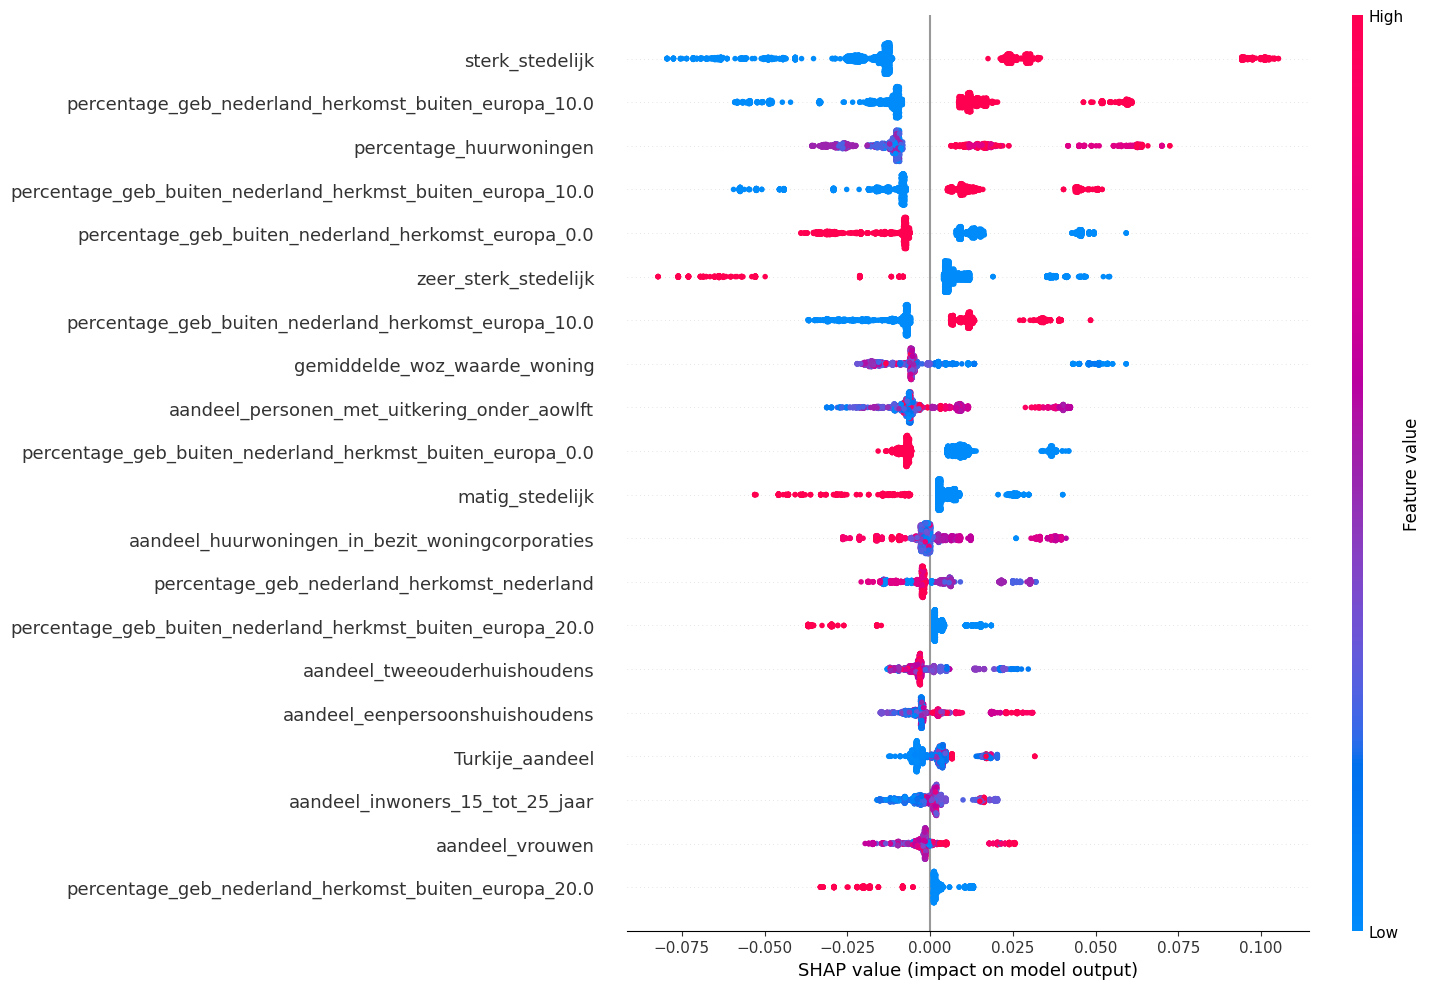

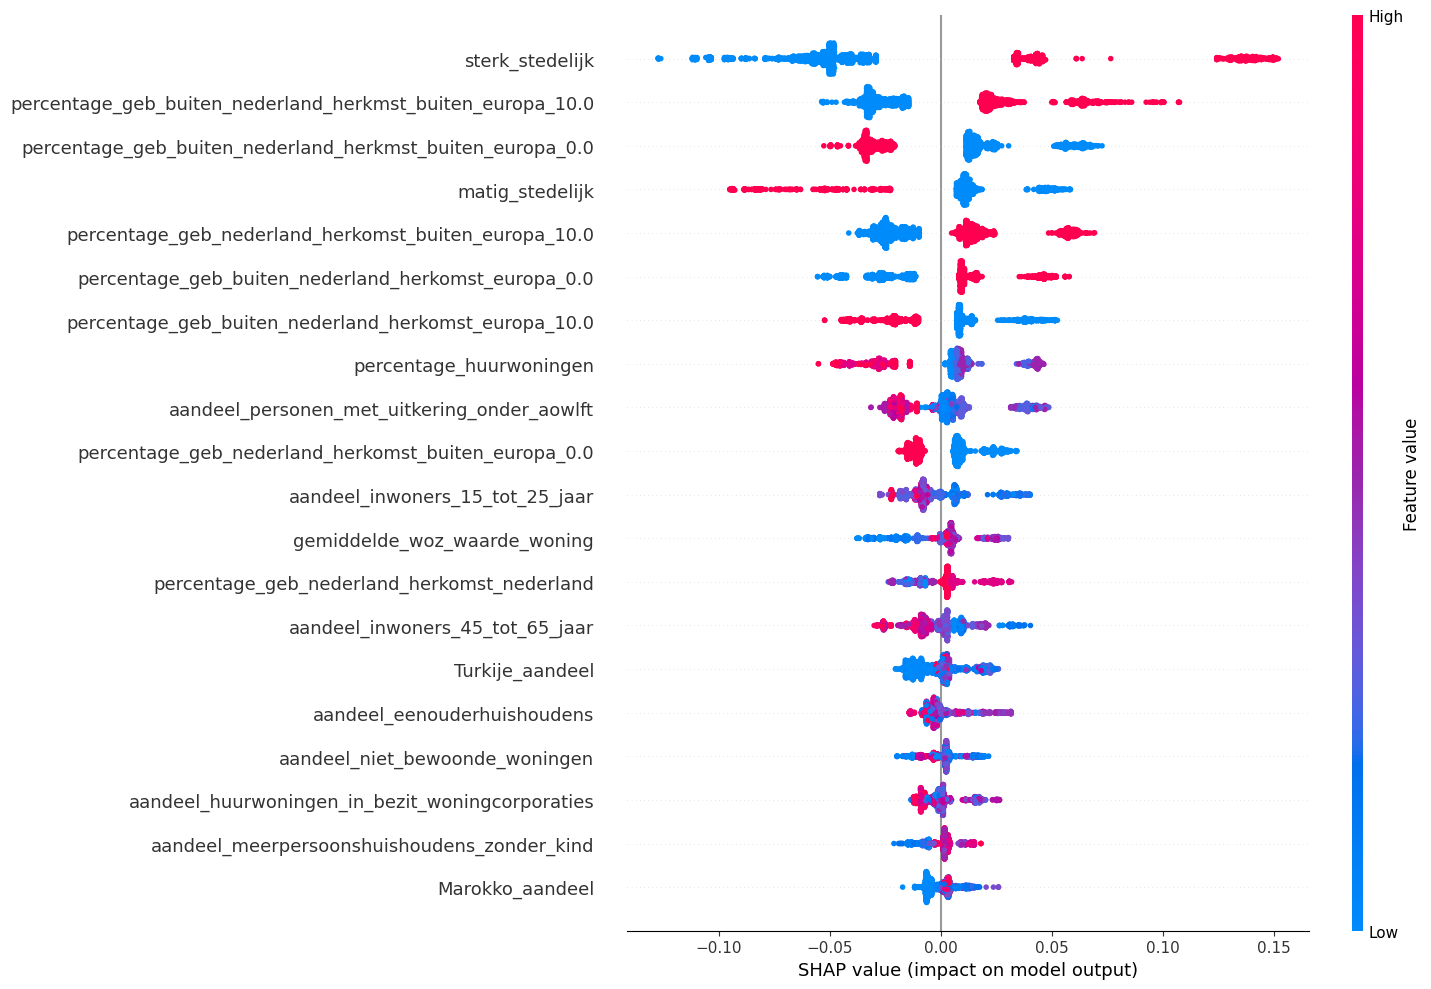

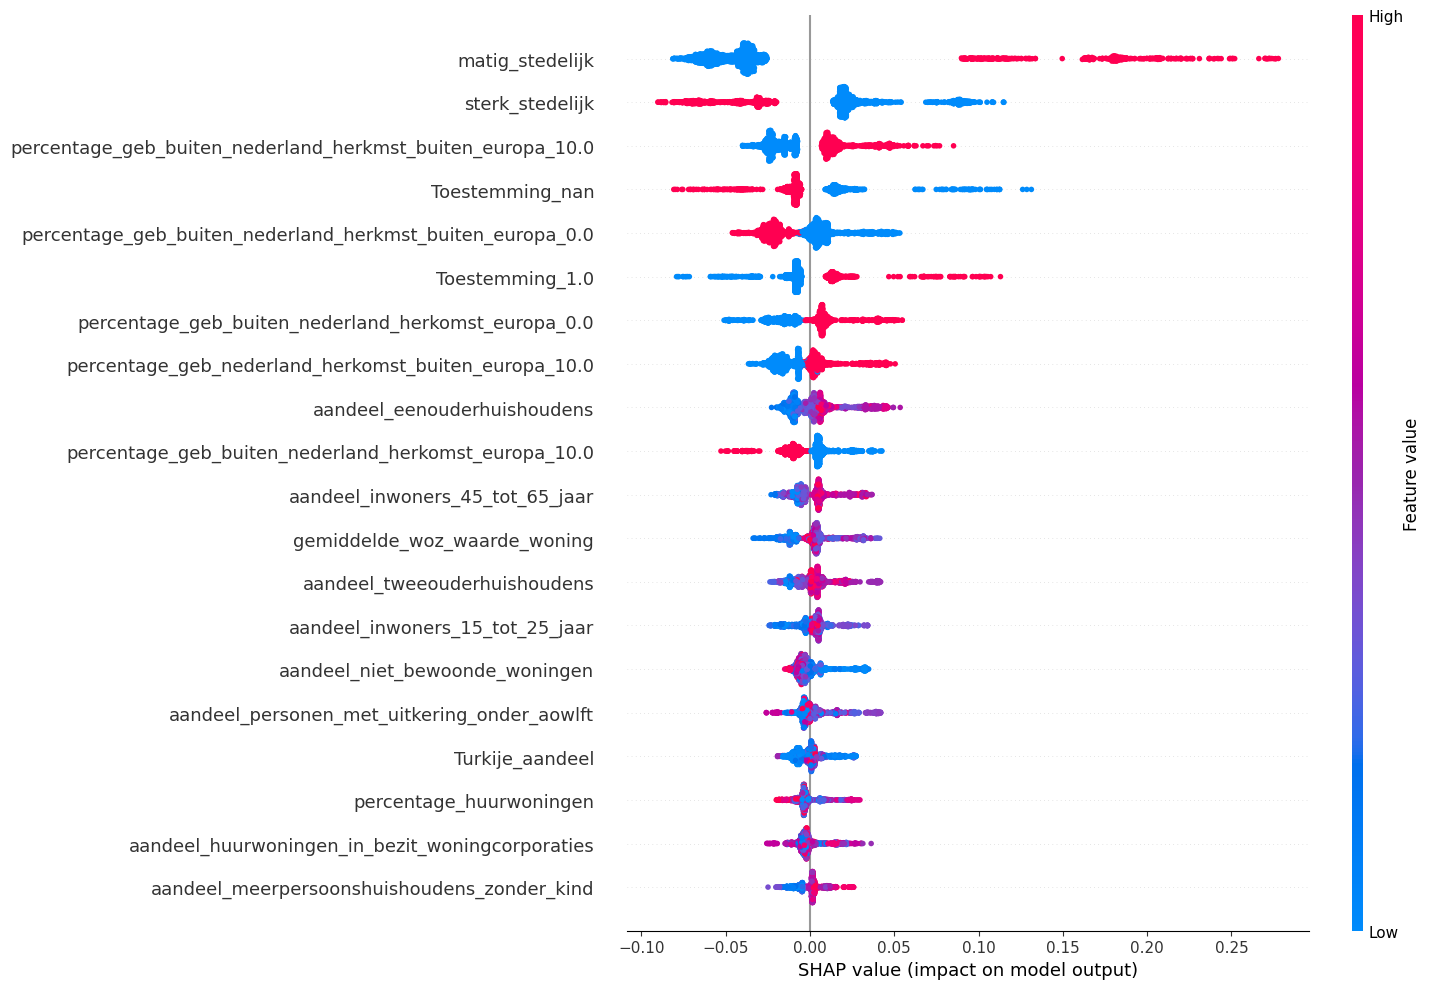

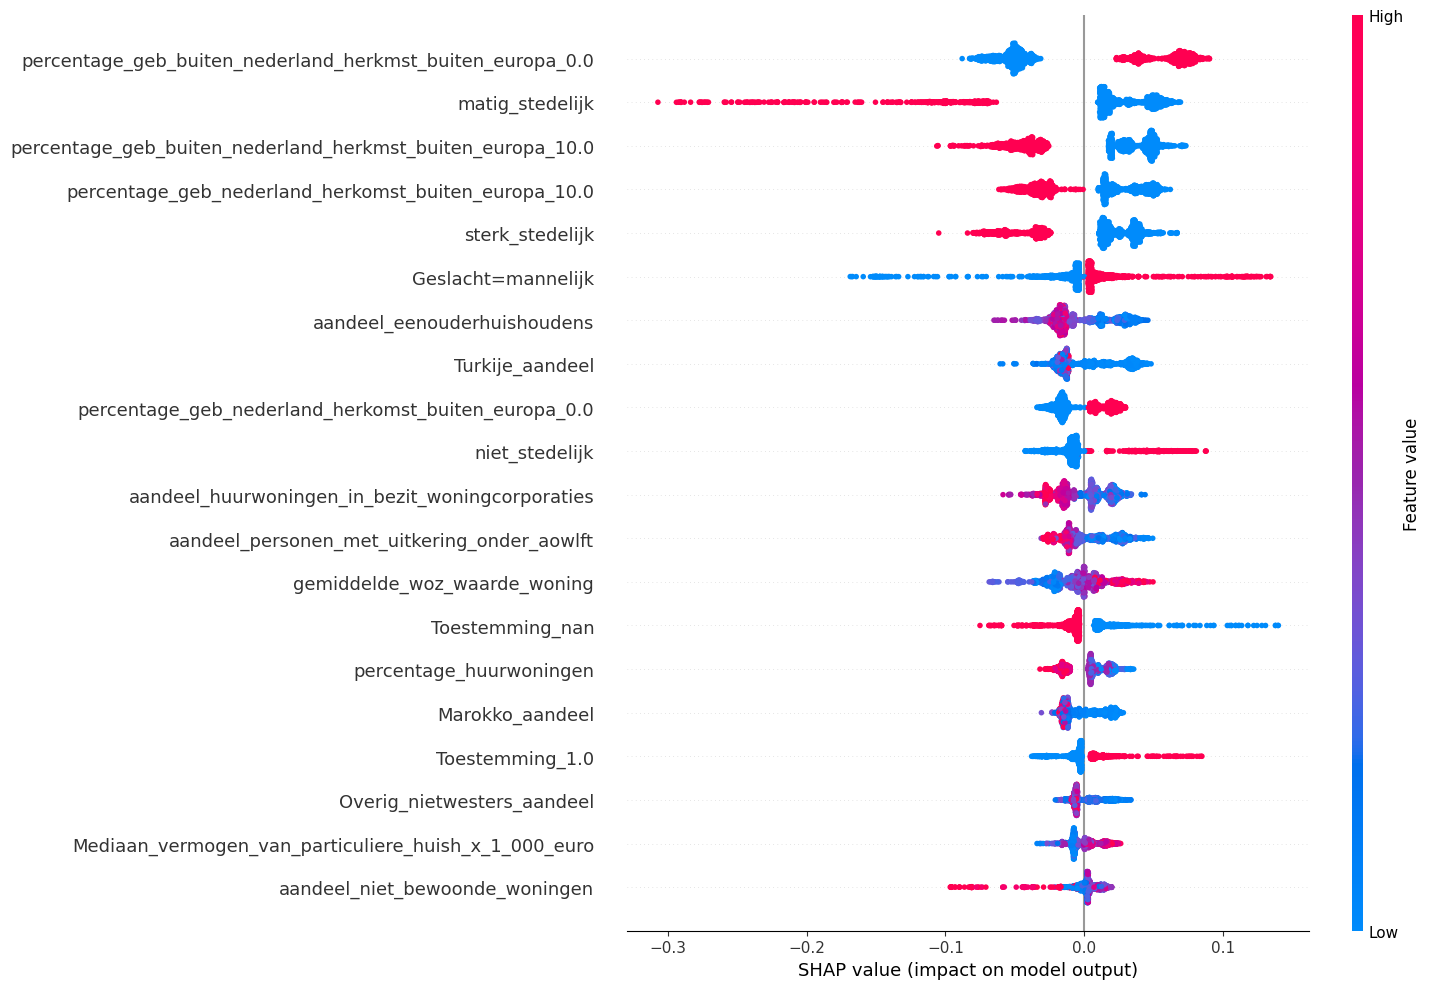

In [19]:
# Print summary plot per cluster
for cluster in range(len(le_classes)):
    shap.summary_plot(shap_values[:, :, cluster], X_train, feature_names=X_train.columns, plot_size=(15, 10))

#### 4.2 Neighbourhood plots

In [20]:
# Take only relevant columns
schoolgaanden_buurt = schoolgaanden[['CBS_Buurtcode_BRP']]

# Add the cluster labels to the original dataset
schoolgaanden_buurt['Cluster_label'] = hdb.labels_

# Get all unique Cluster_label values
all_cluster_labels = schoolgaanden_buurt['Cluster_label'].unique()

# Calculate the percentages of 'Cluster_label' per unique CBS_Buurtcode_BRP
buurt_percentages = schoolgaanden_buurt.groupby('CBS_Buurtcode_BRP')['Cluster_label'].value_counts(normalize=True).unstack().fillna(0)

# Reindex to ensure all unique Cluster_label values are included as columns
buurt_percentages = buurt_percentages.reindex(columns=all_cluster_labels, fill_value=0)

# Reset index
buurt_percentages = buurt_percentages.reset_index()

# Reading GeoPackage file
cbs_df = gpd.read_file('../4_Data/Polygons/buurten_2023_v1.shp')

# Replace every -99997 with NaN
cbs_df = cbs_df.replace(-99997, np.nan)

# From every row in 'BU_CODE' remove the first two characters
cbs_df['BU_CODE'] = cbs_df['BU_CODE'].astype(str).str[2:]

# Define list of relevant municipalities
municipalities = ['Alphen-Chaam',
                  'Altena',
                  'Baarle-Nassau',
                  'Breda',
                  'Drimmelen',
                  'Etten-Leur',
                  'Geertruidenberg',
                  'Halderberge',
                  'Oosterhout',
                  'Zundert',
                  'Moerdijk',
                  'Roosendaal',
                  'Rucphen',
                  'Steenbergen',
                  'Woensdrecht',
                  'Bergen op Zoom']

# Filter the df_pc4 to only include the relevant municipalities
cbs_df = cbs_df[cbs_df['GM_NAAM'].isin(municipalities)]

# Merge polygons with percentages for all clusters
gdf = cbs_df.merge(buurt_percentages[['CBS_Buurtcode_BRP'] + list(range(n_clusters))], left_on='BU_CODE', right_on='CBS_Buurtcode_BRP', how='left')

#### 4.3 Comparison of central tendency

In [21]:
# Take only float64 and int64 columns
X_schoolgaanden_continuous = X_schoolgaanden_notvaccinated.select_dtypes(include=['float64', 'int64'])

# Add 'schoolgaanden_status' to the DataFrame
X_schoolgaanden_continuous['Cluster'] = y_clusters_schoolgaanden

# Group X_schoolgaanden by schoolgaanden_status and calculate mean
grouped_continuous = X_schoolgaanden_continuous.groupby('Cluster').mean()

# Transpose the DataFrame
grouped_continuous = grouped_continuous.T

# Add the calculated measures of central tendency as new columns to grouped_continuous
grouped_continuous['Gemiddelde (niet gevaccineerden)'] = X_schoolgaanden_continuous.mean()
grouped_continuous['Mediaan (niet gevaccineerden)'] = X_schoolgaanden_continuous.median()
grouped_continuous['SD (niet gevaccineerden)'] = X_schoolgaanden_continuous.std()

# Add the calculated box plot statistics as new columns to grouped_continuous
grouped_continuous['Q1 (niet gevaccineerden)'] = X_schoolgaanden_continuous.quantile(0.25)
grouped_continuous['Q3 (niet gevaccineerden)'] = X_schoolgaanden_continuous.quantile(0.75)
grouped_continuous['IQR (niet gevaccineerden)'] = grouped_continuous['Q3 (niet gevaccineerden)'] - grouped_continuous['Q1 (niet gevaccineerden)']
grouped_continuous['Ondergrens uitschieters (niet gevaccineerden)'] = grouped_continuous['Q1 (niet gevaccineerden)'] - 1.5 * grouped_continuous['IQR (niet gevaccineerden)']
grouped_continuous['Bovengrens uitschieters (niet gevaccineerden)'] = grouped_continuous['Q3 (niet gevaccineerden)'] + 1.5 * grouped_continuous['IQR (niet gevaccineerden)']

# Add X_schoolgaanden_vaccinated means and medians to grouped_continuous
grouped_continuous['Gemiddelde (gevaccineerden)'] = X_schoolgaanden_vaccinated.select_dtypes(include=['float64', 'int64']).mean()
grouped_continuous['Mediaan (gevaccineerden)'] = X_schoolgaanden_vaccinated.select_dtypes(include=['float64', 'int64']).median()
grouped_continuous['SD (gevaccineerden)'] = X_schoolgaanden_vaccinated.select_dtypes(include=['float64', 'int64']).std()
grouped_continuous

Cluster,-1,0,1,2,3,4,5,Gemiddelde (niet gevaccineerden),Mediaan (niet gevaccineerden),SD (niet gevaccineerden),Q1 (niet gevaccineerden),Q3 (niet gevaccineerden),IQR (niet gevaccineerden),Ondergrens uitschieters (niet gevaccineerden),Bovengrens uitschieters (niet gevaccineerden),Gemiddelde (gevaccineerden),Mediaan (gevaccineerden),SD (gevaccineerden)
percentage_geb_nederland_herkomst_nederland,74.908257,52.200000,69.380952,66.666667,79.393064,77.701149,85.558476,76.046329,80.000000,12.875721,70.000000,90.000000,20.000000,40.000000,120.000000,80.054783,80.000000,10.240458
percentage_huurwoningen,34.610092,59.000000,59.047619,52.520325,36.820809,35.804598,28.186597,38.814291,40.000000,13.768070,30.000000,50.000000,20.000000,0.000000,80.000000,34.635617,30.000000,12.382072
gemiddelde_woz_waarde_woning,291.227064,224.390000,253.695238,237.906504,307.381503,302.247126,350.065703,299.014527,294.000000,64.048969,259.000000,328.000000,69.000000,155.500000,431.500000,319.948000,310.000000,72.830612
Nettoarbeidsparticipatie_%,64.128922,57.500000,63.414286,60.508130,64.471098,63.859023,67.512116,64.220208,65.000000,5.347046,61.000000,68.000000,7.000000,50.500000,78.500000,65.901928,66.000000,4.778072
Gemiddeld_inkomen_per_inwoner_x_1_000_euro,29.382968,23.868425,28.559129,25.924187,30.245202,29.256348,32.687294,29.635063,29.115000,4.748865,26.503500,32.100000,5.596500,18.108750,40.494750,31.452042,30.317000,4.670994
Huishoudens_laagste_landelijke_40%_huishoudensinkomens_%,36.623713,52.487000,52.945714,48.332114,34.979806,35.400141,31.895736,38.542817,36.500000,11.755325,31.300000,48.500000,17.200000,5.500000,74.300000,34.031585,32.900000,10.782583
Huishoudens_hoogste_landelijke_20%_huishoudensinkomens_%,19.870596,10.912000,12.448571,12.939837,19.892156,19.436144,25.400250,19.481521,18.100000,9.242940,12.200000,24.400000,12.200000,-6.100000,42.700000,23.329721,21.400000,9.797562
Huishoudens_met_een_laag_inkomen_%,4.325479,8.729000,6.613333,6.582520,3.563066,4.214601,3.004457,4.564469,4.000000,2.624656,2.600000,5.600000,3.000000,-1.900000,10.100000,3.616940,3.200000,2.131798
Huish_onder_of_rond_sociaal_minimum_%,5.769589,12.236500,9.157143,9.040244,5.176887,5.969261,3.791206,6.228251,5.400000,3.676021,3.500000,7.800000,4.300000,-2.950000,14.250000,4.902798,4.200000,2.916434
Huishoudens_tot_110%_van_sociaal_minimum_%,8.812624,18.194500,13.905714,13.350813,7.963908,8.869609,5.892733,9.427644,8.400000,5.276614,5.400000,12.100000,6.700000,-4.650000,22.150000,7.440451,6.300000,4.244638


In [22]:
# Take only boolean columns
X_schoolgaanden_categories = X_schoolgaanden_notvaccinated.select_dtypes(include=['boolean', 'category'])
X_schoolgaanden_vaccinated = X_schoolgaanden_vaccinated.select_dtypes(include=['boolean', 'category'])

# Add 'schoolgaanden_status' to the DataFrame
X_schoolgaanden_categories['Cluster'] = y_clusters_schoolgaanden

# Dictionary to store combined DataFrames
combined_dfs = {}

# Loop over each categorical column
for col in X_schoolgaanden_categories.columns:
    if col != 'Cluster':
        # Group by schoolgaanden_status and the current categorical column
        grouped = X_schoolgaanden_categories.groupby(['Cluster', col]).size().unstack().T

        # Calculate percentages
        grouped_pct = grouped.div(grouped.sum(axis=0), axis=1) * 100
        
        # Rename percentage columns to include '(%)'
        grouped_pct.columns = [f"{col} (%)" for col in grouped_pct.columns]

        # Calculate total counts and percentages across all clusters
        total_counts = grouped.sum(axis=1)
        total_pct = total_counts / total_counts.sum() * 100

        # Calculate total counts and percentages in X_schoolgaanden_vaccinated
        total_counts_vaccinated = X_schoolgaanden_vaccinated[col].value_counts()
        total_pct_vaccinated = total_counts_vaccinated / total_counts_vaccinated.sum() * 100
        
        # Add total counts and percentages to the DataFrame
        grouped['Totaal (niet gevaccineerden)'] = total_counts
        grouped_pct['Totaal (niet gevaccineerden) (%)'] = total_pct
        
        # Add total counts and percentages in X_schoolgaanden_vaccinated to the DataFrame
        grouped['Totaal (gevaccineerden)'] = total_counts_vaccinated
        grouped_pct['Totaal (gevaccineerden) (%)'] = total_pct_vaccinated

        # Concatenate counts and percentages horizontally
        combined = pd.concat([grouped, grouped_pct], axis=1)
        
        # Add a new level to the index to preserve the original variable names
        combined.index = pd.MultiIndex.from_product([[col], combined.index])
        
        # Store the combined DataFrame in the dictionary
        combined_dfs[col] = combined

# Concatenate all combined DataFrames vertically
grouped_categories = pd.concat(combined_dfs.values(), axis=0)
grouped_categories

-1      0      1  \
percentage_geb_nederland_herkomst_overig_europa... False   56.0    NaN    NaN   
                                                   True   380.0  200.0  210.0   
percentage_geb_nederland_herkomst_overig_europa... False  380.0  200.0  210.0   
                                                   True    56.0    NaN    NaN   
percentage_geb_nederland_herkomst_overig_europa... False  436.0  200.0  210.0   
                                                   True     NaN    NaN    NaN   
percentage_geb_nederland_herkomst_buiten_europa... False  137.0  200.0  210.0   
                                                   True   299.0    NaN    NaN   
percentage_geb_nederland_herkomst_buiten_europa... False  341.0  200.0    NaN   
                                                   True    95.0    NaN  210.0   
percentage_geb_nederland_herkomst_buiten_europa... False  394.0    NaN  210.0   
                                                   True    42.0  200.0    NaN   
percentage_geb_nederland_herkomst_buiten_europa... False  436.0  200.0  210.0   
                                                   True     NaN    NaN    NaN   
percentage_geb_buiten_nederland_herkomst_europa... False  231.0  200.0  210.0   
                                                   True   205.0    NaN    NaN   
percentage_geb_buiten_nederland_herkomst_europa... False  242.0    NaN    NaN   
                                                   True   194.0  200.0  210.0   
percentage_geb_buiten_nederland_herkomst_europa... False  436.0  200.0  210.0   
                                                   True     NaN    NaN    NaN   
percentage_geb_buiten_nederland_herkomst_europa... False  436.0  200.0  210.0   
                                                   True     NaN    NaN    NaN   
percentage_geb_buiten_nederland_herkomst_europa... False  399.0  200.0  210.0   
                                                   True    37.0    NaN    NaN   
percentage_geb_buiten_nederland_herkomst_europa... False  436.0  200.0  210.0   
                                                   True     NaN    NaN    NaN   
percentage_geb_buiten_nederland_herkmst_buiten_... False  137.0  200.0  210.0   
                                                   True   299.0    NaN    NaN   
percentage_geb_buiten_nederland_herkmst_buiten_... False  341.0  200.0   28.0   
                                                   True    95.0    NaN  182.0   
percentage_geb_buiten_nederland_herkmst_buiten_... False  436.0    NaN  182.0   
                                                   True     NaN  200.0   28.0   
percentage_geb_buiten_nederland_herkmst_buiten_... False  394.0  200.0  210.0   
                                                   True    42.0    NaN    NaN   
percentage_geb_buiten_nederland_herkmst_buiten_... False  436.0  200.0  210.0   
                                                   True     NaN    NaN    NaN   
zeer_sterk_stedelijk                               False  394.0  200.0    NaN   
                                                   True    42.0    NaN  210.0   
sterk_stedelijk                                    False  434.0    NaN  210.0   
                                                   True     2.0  200.0    NaN   
matig_stedelijk                                    False  265.0  200.0  210.0   
                                                   True   171.0    NaN    NaN   
weinig_stedelijk                                   False  253.0  200.0  210.0   
                                                   True   183.0    NaN    NaN   
niet_stedelijk                                     False  398.0  200.0  210.0   
                                                   True    38.0    NaN    NaN   
stedelijkheid_nan                                  False  436.0  200.0  210.0   
Toestemming_0.0                                    False  433.0  196.0  205.0   
                                                   True     3.0    4.0    5.0   
Toestemming

#### 4.4 Structure and save results

In [23]:
# Print general info
print(f'In de data zijn {n_clusters} clusters gevonden. Het cluster waartoe een individu behoort kan op basis van zijn of haar kenmerken voorspeld worden met een \'accuracy\' van {accuracy:.2f}.')
# Example value for 'today'
today = datetime.now().strftime('%Y-%m-%d')
# Make target folder to place plots
os.makedirs(f'../9_Results\\Schoolgaanden\\Not_vaccinated\\15D\\{today}_Clusters')

In de data zijn 6 clusters gevonden. Het cluster waartoe een individu behoort kan op basis van zijn of haar kenmerken voorspeld worden met een 'accuracy' van 0.98.


In [24]:
# Split the array into a list of arrays, one for each class
multi_shap_vals = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# Plot the SHAP values with feature names
shap.summary_plot(multi_shap_vals, X_train.values, plot_type='bar', class_names=le_classes, feature_names=X_train.columns, plot_size=(15, 10), show=False)
plt.title('SHAP Summary Plot')
plt.savefig(f'../9_Results\\Schoolgaanden\\Not_vaccinated\\15D\\{today}_Clusters\\SHAP_summary_plot.jpg', dpi=300, bbox_inches='tight')
plt.close()

# Save grouped_continuous and grouped_categories to a .xlsx file on two separate sheets
with pd.ExcelWriter(f'../9_Results\\Schoolgaanden\\Not_vaccinated\\15D\\{today}_Clusters\\Clusterkenmerken.xlsx') as writer:
    grouped_continuous.to_excel(writer, sheet_name='Kenmerken_continu')
    grouped_categories.to_excel(writer, sheet_name='Kenmerken_categorisch')

# If -1 is in the labels, begin with second color in palette
if -1 in hdb.labels_:
    plt.figure(figsize=(12, 7))
    plt.title(f'HDBSCAN clustering - (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette()[1:])
    plt.savefig(f'../9_Results\\Schoolgaanden\\Not_vaccinated\\15D\\{today}_Clusters\\HDBSCAN_tree.jpg', dpi=300, bbox_inches='tight')
    plt.close()
else:
    plt.figure(figsize=(12, 7))
    plt.title(f'HDBSCAN clustering - (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    plt.savefig(f'../9_Results\\Schoolgaanden\\Not_vaccinated\\15D\\{today}_Clusters\\HDBSCAN_tree.jpg', dpi=300, bbox_inches='tight')
    plt.close()

# Print summary plot per cluster
for cluster in range(1, n_clusters+1):

    # Make target folder to place plots
    os.makedirs(f'../9_Results\\Schoolgaanden\\Not_vaccinated\\15D\\{today}_Clusters\\Cluster_{cluster}')
    
    # Calculate shap dim
    if -1 in y_clusters_schoolgaanden:
        cluster_dim = cluster
    else:
        cluster_dim = cluster - 1
    
    # Plot the SHAP summary plot
    shap.summary_plot(shap_values[:, :, cluster_dim], X_train, feature_names=X_train.columns, plot_size=(15, 10), show=False, max_display=15)
    plt.title(f'SHAP cluster {cluster} plot')
    plt.savefig(f'../9_Results\\Schoolgaanden\\Not_vaccinated\\15D\\{today}_Clusters\\Cluster_{cluster}\\SHAP_cluster_plot.jpg', dpi=300, bbox_inches='tight')
    plt.close()

    # Plot neighbourhoods
    cmap = mcolors.LinearSegmentedColormap.from_list('unidirectional', ['lightcoral', 'darkred'])
    gdf.plot(column=cluster-1,
            cmap=cmap,
            legend=True)
    plt.axis('off')
    plt.title(f'Niet-gevaccineerden per buurt - Cluster {cluster} (*100%)')
    plt.savefig(f'../9_Results\\Schoolgaanden\\Not_vaccinated\\15D\\{today}_Clusters\\Cluster_{cluster}\\Neighbourhoods.jpg', dpi=300, bbox_inches='tight')
    plt.close()